# Multi-label Classification of Surabaya City Communities Report Through Twitter Social Media

# Import Libraries

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate, Flatten, CuDNNGRU, CuDNNLSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GRU, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve
from gensim.models.keyedvectors import KeyedVectors

import sklearn.metrics as skm
from sklearn.metrics import hamming_loss

import gc
import re

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


# Load Dataset

In [2]:
data = pd.read_excel('Data-Surabaya.xlsx')
data

,text,ADU,INF,TNY,APR,SRN,SDA,LLN,PUB,FSU,BCN,TPL,HLG,EVE
0,Sangar cak salut salam satu nyali. WANI!!! @persebayaupdate @aslisuroboyo @LoveSuroboyo https://t.co/k7ECzeumJE,0,0,0,1,0,0,0,0,0,0,0,0,0
1,temen temen ada yang tau ga hi-tech mall sebenernya masih buka atau udah tutup permanen? kira kira pengganti nya dimana ya? bener bener butuh banget :(tolong bantuin info yaa makasih banyak @e100ss @infosurabaya @aslisuroboyo @SapawargaSby @HiTechMallSby,0,0,1,0,0,0,0,0,1,0,0,0,0
2,min @aslisuroboyo mak bongki saiki nangdi ya?,0,0,1,0,0,0,0,0,0,0,0,0,0
3,"Cuma mau bilamg , gua nonggol di ig @aslisuroboyo 😎 https://t.co/ygZxRlbbVw",0,1,0,0,0,0,0,0,0,0,0,0,0
4,Gak nyongko nek iki jek #surabaya@aslisuroboyo t,0,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,Masih bingung cari transportasi saat liburan di malang? Dm/wa/call 085933003234 @infosurabaya @infomalang @LMsurabaya #WeekendSantuy #Liburan #PesonaIndonesia #beautifulmalang #shiningbatu https://t.co/PLxVwlCbDc,0,1,0,0,0,0,0,0,1,0,0,0,0
1024,Project galian pipa @PDAMSurabaya jadi penyebab kemacetan di simpang Pandegiling-Urip Sumoharjo. Semoga bisa segera diselesaikan. @infosurabaya @pemkotsby https://t.co/GPzu6V0h7k,0,0,0,0,1,0,1,0,0,0,0,0,0
1025,"Berkah Hibah Aset Pemerintah dari @DitjenKN untuk @SapawargaSby. Bu Risma: ""Lahan ditengah kota sudah sangat sulit untuk kita bebaskan, untuk area pendidikan"" ""Kita tetapkan aset yang diberikan Ditjen Kekayaan Negara ini untuk pendidikan"". https://t.co/gKdsBV3Sgn",0,1,0,0,0,0,0,0,0,0,0,0,0
1026,"nah, jam pelayanan belum tutup kan? @SapawargaSby #kantorkelurahanJagir https://t.co/rOVcmMY5Ly",0,0,1,0,0,0,0,1,0,0,0,0,0


Penjelasan

1. ADU : Aduan = Hal-hal yang berkaitan dengan keluhan masyarakat yang membutuhkan tindak lanjut atau penanganan dari Lembaga yang berwenang.
2. INF : Informasi = Berisi informasi yang disebarkan dan tidak memerlukan penanganan. 
3. TNY : Pertanyaan = Berisi pertanyaan masyarakat atau permintaan informasi baik untuk Lembaga terkait atau untuk masyarakat lainnya. 
4. APR : Apresiasi = Berisi pujian, penyampaian terimakasih dan hal-hal positif lainnya yang memiliki tujuan untuk menyampaikan tujuan.
5. SRN : Saran = Berisi usulan tindakan yang bisa dilakukan lembaga terkait atau masyarakat lainnya yang sifatnya tidak memaksa dan bertujuan untuk meningkatkan kualitas. 
6. SDA : Sumber Daya = Berhubungan dengan segala sesuatu yang berperan dalam memenuhi kebutuhan masyarakat seperti listrik, air, internet, gas. 
7. LLN : Lalu Lintas = Berhubungan dengan segala hal pada lalu lintas, seperti kemacetan, kecelakaan, jalan ditutup dan lain-lain.
8. PUB : Layanan Publik = Berhubungan dengan pelayanan publik kepada masyarakat seperti layanan pembuatan KTP, KK, SIM, BPJS, dan lain-lain. 
9. FSU : Fasilitas Umum = Berhubungan dengan fasilitas untuk masyarakat umum seperti kendaraan umum, halte, stasiun, ATM, Tempat hiburan seperti mall, tempat wisata dan ruang publik seperti taman dll.
10. BCN : Bencana = Berhubungan dengan bencana yang terjadi seperti info banjir, tanah longsor, gempa, aduan kebakaran dan lain-lain. 
11. TPN : Tindak Pelanggaran = Berhubungan dengan segala tindakan yang melanggar hukum dan Undang-undang. Melanggar hukum seperti tindak kejahatan pencurian, pencopetan, perampokan, pembunuhan dll. Tindakan pelanggaran undang-undang seperti pelanggaran pemasangan spanduk, perusakan fasilitas umum dll.
12. HLG : Kehilangan = Berhubungan dengan barang hilang dan barang yang ditemukan.
13. EVE : Event = Berhubungan dengan pembahasan tentang adanya acara atau event tertentu. 

# Preprocessing

In [3]:
def replace_mention(string):
    tokens = ['' if token.startswith('@') else token for token in string.split()]
    return ' '.join(tokens)

def replace_URL(string):
    tokens = ['' if 'http' in token else token for token in string.split()]
    return ' '.join(tokens) 

def replace_mult_occurences(string):
    return re.sub(r'(.)\1{2,}', r'\1\1', string) 

def replace_hastag(string):
    tokens = ['' if token.startswith('#') else token for token in string.split()]
    return ' '.join(tokens)
 
def preprocess(data, text):
    data['text_bersih'] = data[text].apply(replace_mention)
    data['text_bersih'] = data['text_bersih'].apply(replace_URL)
    data['text_bersih'] = data['text_bersih'].apply(replace_mult_occurences)
    data['text_bersih'] = data['text_bersih'].apply(replace_hastag)
    data['text_bersih'] = data['text_bersih'].str.replace('[^\w\s#/:%.,-]', '', flags=re.UNICODE)
    data['text_bersih'] = data['text_bersih'].str.replace('.', ' ')
    data['text_bersih'] = data['text_bersih'].str.replace('#', ' ')
    data['text_bersih'] = data['text_bersih'].str.replace(',', ' ')
    data['text_bersih'] = data['text_bersih'].str.replace('-', ' ')
    data['text_bersih'] = data['text_bersih'].str.replace(':', ' ')
    data['text_bersih'] = data['text_bersih'].str.lower()

In [4]:
preprocess(data, 'text')

In [5]:
data

,text,ADU,INF,TNY,APR,SRN,SDA,LLN,PUB,FSU,BCN,TPL,HLG,EVE,text_bersih
0,Sangar cak salut salam satu nyali. WANI!!! @persebayaupdate @aslisuroboyo @LoveSuroboyo https://t.co/k7ECzeumJE,0,0,0,1,0,0,0,0,0,0,0,0,0,sangar cak salut salam satu nyali wani
1,temen temen ada yang tau ga hi-tech mall sebenernya masih buka atau udah tutup permanen? kira kira pengganti nya dimana ya? bener bener butuh banget :(tolong bantuin info yaa makasih banyak @e100ss @infosurabaya @aslisuroboyo @SapawargaSby @HiTechMallSby,0,0,1,0,0,0,0,0,1,0,0,0,0,temen temen ada yang tau ga hi tech mall sebenernya masih buka atau udah tutup permanen kira kira pengganti nya dimana ya bener bener butuh banget tolong bantuin info yaa makasih banyak
2,min @aslisuroboyo mak bongki saiki nangdi ya?,0,0,1,0,0,0,0,0,0,0,0,0,0,min mak bongki saiki nangdi ya
3,"Cuma mau bilamg , gua nonggol di ig @aslisuroboyo 😎 https://t.co/ygZxRlbbVw",0,1,0,0,0,0,0,0,0,0,0,0,0,cuma mau bilamg gua nonggol di ig
4,Gak nyongko nek iki jek #surabaya@aslisuroboyo t,0,1,0,1,0,0,0,0,0,0,0,0,0,gak nyongko nek iki jek t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,Masih bingung cari transportasi saat liburan di malang? Dm/wa/call 085933003234 @infosurabaya @infomalang @LMsurabaya #WeekendSantuy #Liburan #PesonaIndonesia #beautifulmalang #shiningbatu https://t.co/PLxVwlCbDc,0,1,0,0,0,0,0,0,1,0,0,0,0,masih bingung cari transportasi saat liburan di malang dm/wa/call 085933003234
1024,Project galian pipa @PDAMSurabaya jadi penyebab kemacetan di simpang Pandegiling-Urip Sumoharjo. Semoga bisa segera diselesaikan. @infosurabaya @pemkotsby https://t.co/GPzu6V0h7k,0,0,0,0,1,0,1,0,0,0,0,0,0,project galian pipa jadi penyebab kemacetan di simpang pandegiling urip sumoharjo semoga bisa segera diselesaikan
1025,"Berkah Hibah Aset Pemerintah dari @DitjenKN untuk @SapawargaSby. Bu Risma: ""Lahan ditengah kota sudah sangat sulit untuk kita bebaskan, untuk area pendidikan"" ""Kita tetapkan aset yang diberikan Ditjen Kekayaan Negara ini untuk pendidikan"". https://t.co/gKdsBV3Sgn",0,1,0,0,0,0,0,0,0,0,0,0,0,berkah hibah aset pemerintah dari untuk bu risma lahan ditengah kota sudah sangat sulit untuk kita bebaskan untuk area pendidikan kita tetapkan aset yang diberikan ditjen kekayaan negara ini untuk pendidikan
1026,"nah, jam pelayanan belum tutup kan? @SapawargaSby #kantorkelurahanJagir https://t.co/rOVcmMY5Ly",0,0,1,0,0,0,0,1,0,0,0,0,0,nah jam pelayanan belum tutup kan


# Split Data

In [6]:
train, test = train_test_split(data, test_size=0.2, random_state = 23)
train = train.reset_index()
test = test.reset_index()
train

,index,text,ADU,INF,TNY,APR,SRN,SDA,LLN,PUB,FSU,BCN,TPL,HLG,EVE,text_bersih
0,937,#ItB#traffic MALANG Kota di Sunandar-Suryo-berkuda-PangSud RAMAI&gt;PADAT di Sanan &amp; SMPN5 &amp; Sp. Pandean &amp; A&amp;R PADAT#cuaca BERAWAN @e100ss #lalin #LaluLintas @LalinNews @PuspitaFM,0,1,0,0,0,0,1,0,0,0,0,0,0,malang kota di sunandar suryo berkuda pangsud ramaigtpadat di sanan amp smpn5 amp sp pandean amp aampr padat cuaca berawan
1,37,Min @BanggaSurabaya @SapawargaSbyakun Puskesmas Simomulyo opo ? Daftar online waktu klik ambil nomer antrian munyer² https://t.co/7xpveDSdu0,1,0,0,0,0,0,0,1,0,0,0,0,0,min puskesmas simomulyo opo daftar online waktu klik ambil nomer antrian munyer²
2,545,Min info soal PDAM daerah bendul mati tiba tiba @e100ss,1,1,0,0,0,1,0,0,0,0,0,0,0,min info soal pdam daerah bendul mati tiba tiba
3,334,betul banget iki @e100ss https://t.co/8Bo2eOnWGW,0,0,0,0,0,0,0,0,0,0,0,0,0,betul banget iki
4,684,Min @e100ss mohon info air mati di daerah Dinoyo dan sekitarnya sampai kapan ya @PDAMSurabaya,0,0,1,0,0,1,0,0,0,0,0,0,0,min mohon info air mati di daerah dinoyo dan sekitarnya sampai kapan ya
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,237,"Barang kali ada yg sering melintasi raya lontar monggo disimak @e100ss @SapawargaSby mungkin jg bisa dibantu pengaturan lalu lintasnya 1arah mungkin, krn satu2nya akses jln warga menuju hrm&amp;mayjend @PolrestabesSby https://t.co/frzxypSDlp",0,1,0,0,1,0,1,0,0,0,0,0,0,barang kali ada yg sering melintasi raya lontar monggo disimak mungkin jg bisa dibantu pengaturan lalu lintasnya 1arah mungkin krn satu2nya akses jln warga menuju hrmampmayjend
818,31,Apa ada masalah lagi air pdam mampet?? Mhon quick respon utk mslah ini bisa segera selesai@BanggaSurabaya Cc @PDAMSurabaya @SapawargaSby @Commandsurabaya,1,0,1,0,0,1,0,0,0,0,0,0,0,apa ada masalah lagi air pdam mampet mhon quick respon utk mslah ini bisa segera selesaibanggasurabaya cc
819,950,sinau bareng #maiyah #CakNun @e100ss https://t.co/zYx9FIlbop,0,0,0,0,0,0,0,0,0,0,0,0,1,sinau bareng
820,742,Mobil truk dari tol arah porong ke waru muatannya over load.. Zig zag juga jalannya.. Isi muatannya kayu spertinya..ambil kanan jalan terus.. Cc @e100ss https://t.co/C3ZmWXoXei,1,1,0,0,0,0,1,0,0,0,1,0,0,mobil truk dari tol arah porong ke waru muatannya over load zig zag juga jalannya isi muatannya kayu spertinya ambil kanan jalan terus cc


In [7]:
list_classes = ['ADU','INF','TNY','APR','SRN','SDA','LLN','PUB','FSU','BCN','TPL','HLG','EVE']
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["text_bersih"]
list_sentences_test = test["text_bersih"]

# Tokenize and Generate Token

In [8]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
list_tokenized_train[1]

[30, 1601, 1602, 366, 1603, 550, 322, 1604, 323, 722, 128, 1605]

In [9]:
list_sentences_train[1]

'min puskesmas simomulyo opo  daftar online waktu klik ambil nomer antrian munyer²'

In [10]:
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [11]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

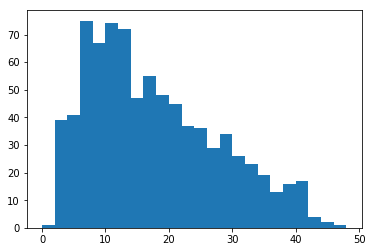

In [12]:
plt.hist(totalNumWords,bins = np.arange(0,50,2))
plt.show()

# Word Embedding

In [13]:
def create_fold_embeddings(embeddings_dim, key_vector):
    
    emb_init_values = []
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():  # Untuk memastikan bahwa urut
        if word == '<unk>':
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))

        elif word == '<pad>':
            emb_init_values.append(np.zeros(embeddings_dim).astype('float32'))
                    
        elif word in key_vector.wv.vocab:
            emb_init_values.append(key_vector.wv.word_vec(word))
            b = b+1
        else:
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
            a = a+1
            unk.append(word)
            # print(word)
    emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
    known_word = b
    unknown_word = a

    print(known_word, unknown_word)

    return known_word, unknown_word, emb_init_values

In [14]:
#Loading pre-trained embeddings
print("loading word2vec...")
# start = time.time()
word_vectors = KeyedVectors.load_word2vec_format("modelapik.bin",
                                                 binary="True", unicode_errors='ignore')
# end = time.time()
# print("word2vec loading done in {} seconds".format(end-start))

word2vec = word_vectors
embed_dim = 300

loading word2vec...


In [15]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

3705 454
known words: 3705
unknown words: 454


# Model

Metrics AUC

In [16]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print(" ROC-AUC - epoch: %d - score: %.6f" % (epoch+1, score))

Build, Train and Test Model

In [17]:
def play_model(arch='LSTM',optimizer='Adam', lr=0.001):
    print('Bulid Model')
    print('............ \n')
    inp = Input(shape=(maxlen,))
    x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=False)(inp)
    if arch == 'GRU':
        x = GRU(200, return_sequences=True)(x)
    elif arch == 'SimpleRNN':
        x = SimpleRNN(200, return_sequences=True)(x)
    else :
        x = LSTM(200, return_sequences=True)(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(100)(x)
    x = Dropout(0.1)(x)
    x = Dense(50)(x)
    x = Dropout(0.1)(x)
    x = Dense(28, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(13, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=x)
    if optimizer == 'SGD':
        opt = optimizers.SGD(lr=lr)
    elif optimizer == 'RMSprop':
        opt = optimizers.RMSprop(lr=lr)
    else:
        opt = optimizers.Adam(lr=lr)
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    #model.summary()
    
    print('Train Model \n')
    batch_size = 32
    epochs = 5

    # file_path="weights_base.best.hdf5"
    RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
    # checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))
    
    print('\n Test Model')
    y_pred = model.predict(X_te)
    y_pred[y_pred>=0.23] = 1
    y_pred[y_pred<0.23] = 0
    cm = skm.multilabel_confusion_matrix(y_te, y_pred)
    print('\n Confusion Matrix')
    print(cm)
    print('\n Classification Report')
    print( skm.classification_report(y_te,y_pred))
    print('Hamming loss: {0}'.format(hamming_loss(y_te, y_pred)))
    print('ROC AUC Score: {0}'.format(roc_auc_score(y_te, y_pred)))
    return y_pred

# Train Model and Prediction Result

In [23]:
pred = play_model(arch='LSTM',optimizer='Adam', lr=0.001)

Bulid Model
............ 

Train Model 

Train on 822 samples, validate on 206 samples
Epoch 1/5
 - 4s - loss: 0.5531 - acc: 0.7249 - val_loss: 0.4314 - val_acc: 0.8469
 ROC-AUC - epoch: 1 - score: 0.599811
Epoch 2/5
 - 3s - loss: 0.4414 - acc: 0.8135 - val_loss: 0.3628 - val_acc: 0.8581
 ROC-AUC - epoch: 2 - score: 0.655414
Epoch 3/5
 - 3s - loss: 0.4104 - acc: 0.8272 - val_loss: 0.3483 - val_acc: 0.8581
 ROC-AUC - epoch: 3 - score: 0.714666
Epoch 4/5
 - 3s - loss: 0.3818 - acc: 0.8363 - val_loss: 0.3305 - val_acc: 0.8768
 ROC-AUC - epoch: 4 - score: 0.732609
Epoch 5/5
 - 3s - loss: 0.3567 - acc: 0.8538 - val_loss: 0.3063 - val_acc: 0.8839
 ROC-AUC - epoch: 5 - score: 0.741923

 Test Model

 Confusion Matrix
[[[ 93  60]
  [  6  47]]

 [[  0  81]
  [  0 125]]

 [[ 73  94]
  [  9  30]]

 [[193   0]
  [ 13   0]]

 [[198   0]
  [  8   0]]

 [[165  12]
  [ 11  18]]

 [[  0 118]
  [  0  88]]

 [[198   1]
  [  7   0]]

 [[190   0]
  [ 16   0]]

 [[191   0]
  [ 15   0]]

 [[199   0]
  [  7   

In [24]:
data_test_pred = pd.DataFrame({'_ADU': pred[:, 0], '_INF': pred[:, 1], '_TNY': pred[:, 2], '_APR': pred[:, 3], 
                               '_SRN': pred[:, 4], '_SDA': pred[:, 5], '_LLN': pred[:, 6], '_PUB': pred[:, 7], 
                               '_FSU': pred[:, 8], '_BCN': pred[:, 9], '_TPL': pred[:, 10], '_HLG': pred[:, 11], 
                               '_EVE': pred[:, 12]})

In [25]:
data_test = pd.concat([test, data_test_pred], axis=1)
data_test

,index,text,ADU,INF,TNY,APR,SRN,SDA,LLN,PUB,FSU,BCN,TPL,HLG,EVE,text_bersih,_ADU,_INF,_TNY,_APR,_SRN,_SDA,_LLN,_PUB,_FSU,_BCN,_TPL,_HLG,_EVE
0,700,#ItB#traffic di #Tol #TransJawa #Tol gate Waru Utama arah SURABAYA RAMAI LANCAR antrian OK &amp; arah MALANG RAMAI LANCAR#cuaca BERAWAN@e100ss #lalin #LaluLintas @SITS_DisHubSby @PTJasaMarga,0,1,0,0,0,0,1,0,0,0,0,0,0,di gate waru utama arah surabaya ramai lancar antrian ok amp arah malang ramai lancar cuaca berawane100ss,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,166,"Pengen spotselfi di sini.@ainissfm ,@e100ss . https://t.co/5pPefH4Qbb",0,0,0,0,0,0,0,0,0,0,0,0,0,pengen spotselfi di sini ainissfm e100ss,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,596,Walaupun super macet di margomulyo..Bapak2 tukang pentol adalah penolong terbaik..@e100ss @sits_dishubsby @PolrestabesSby https://t.co/uCfQE9jKSo,1,0,0,1,0,0,1,0,0,0,0,0,0,walaupun super macet di margomulyo bapak2 tukang pentol adalah penolong terbaik e100ss,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,756,"Telah ditemukan dompet berwarna coklat di sekitaran Jl. Kendangsari, di dalamnya ada beberapa kartupenting a/n Bagus Imam Al-Haq. Bagi yang merasa kehilangan, silakan hubungi Pak Yohanes Adi (082242009494)Cc @e100ss https://t.co/Sllmgn4yQf",0,1,0,0,0,0,0,0,0,0,0,1,0,telah ditemukan dompet berwarna coklat di sekitaran jl kendangsari di dalamnya ada beberapa kartupenting a/n bagus imam al haq bagi yang merasa kehilangan silakan hubungi pak yohanes adi 082242009494cc,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,506,min tolong infokan @e100ss air di daerah tambaksari kapan nyalanya ya 😭 @PDAMSurabaya Terimakasih ditunggu infonya,1,0,1,0,0,1,0,0,0,0,0,0,0,min tolong infokan air di daerah tambaksari kapan nyalanya ya terimakasih ditunggu infonya,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,118,07.07branjangan arah ke sby macet totalbanyak yg lawan arus dan bikin makin macetekor kemungkinan sudah sampai osowilangun karena sudah banyak yg lawan arus lewat putar balikan depan terminaldominasi kendaraan sepeda motor@e100ss,1,0,0,0,0,0,1,0,0,0,1,0,0,07 07branjangan arah ke sby macet totalbanyak yg lawan arus dan bikin makin macetekor kemungkinan sudah sampai osowilangun karena sudah banyak yg lawan arus lewat putar balikan depan terminaldominasi kendaraan sepeda motore100ss,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
202,852,info lampu mati daerah Manukan Sikatan sampai jam brp @e100ss @pln_123,0,1,0,0,0,0,0,0,1,0,0,0,0,info lampu mati daerah manukan sikatan sampai jam brp,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
203,1010,Ada yg dapat email kayak gini juga? @e100ss https://t.co/ZPh69F9Y4f,0,0,1,0,0,0,0,0,0,0,0,0,0,ada yg dapat email kayak gini juga,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
204,865,call center PGN berapa ya?udah beberapa minggu ini tiap pagi selalu mati gas nya😶@e100ss @SapawargaSby,1,0,0,0,0,1,0,0,0,0,0,0,0,call center pgn berapa yaudah beberapa minggu ini tiap pagi selalu mati gas nyae100ss,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
